# The Battle of Neighbourhoods
---

### Introduction
New York City is known as one of the most expensive cities in the world. Property prices in this city are among the highest in the world. This makes New York an attractive - yet equally competitive - market for realtors.

We're going to dive deeper into the property market to find out which districts and neighbourhoods are likely to provide realtors with the highest returns. We'll take a look at sales data from 2020 and use both median prices as well as the number of transactions to arrive at a conclusion.

As a secondary objective, we'll test the hypothesis that people are willing to pay more when there are more amenities close by - as there would be a perceived increase in convenience. We're expecting the average rating for the nearby locations to be in an average range between 3.5 and 4.0 as people in these areas are likely to have high expectations.

### Data
#### We'll be using data from the following sources:
- [Foursquare](https://foursquare.com/) - Foursquare will be used to grab location data for the different neighbourhoods. It will include the latitudes and longitudes, as well as data for the locations nearest to a set of coordinates.
- [OpenCage Geocoder](https://opencagedata.com/) - Geocoder will be used to generate the coordinates for each of the different locations, which will then be used to visualize the locations on a map using folium.
- [Timeout](https://www.timeout.com/newyork/news/these-are-the-new-most-expensive-neighborhoods-in-nyc-010621) - Timeout will be used to get the sales data required for both the median prices and the number of transactions per location.

#### We'll use the following process:
1. Download the table in the Timeout article and import the csv using pandas to get the data we need
2. Add the data to a pandas dataframe and remove irrelevant columns
3. Process the data and ensure it's in a usable state
4. Use Geocoder to generate coordinates for each location
5. Merge the coordinates data with dataframe containing the Timeout data
6. Plot the coordinates onto a map to get our first visual representation of the data
7. Use the Foursquare API to get the necessary data related to our secondary objective
8. Merge this data with the existing dataframe
9. Plot the coordinates onto a map to get another visual representation of the data
10. Run the dataframe through a KMeans clustering algorithm
11. Merge the KMeans cluster data with the existing dataframe
12. Plot the coordinates onto a map and get a final visual representation of the data

# Let's start programming
---
## Import packages

In [1]:
# Import required packages
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import geocoder
import folium
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
print("Imported packages...")

Imported packages...


## Import Timeout Data

In [2]:
# Read data from csv and create a pandas dataframe
t_data = pd.read_csv("data-tmarL.csv")
print("Data imported...")
# Remove Ranking column as it's irrelevant
t_data = t_data.drop(columns=["Ranking"])
print("Ranking column removed...")

Data imported...
Ranking column removed...


In [3]:
# Calculate total income
total_income = t_data['Transactions']*t_data['Median Sales Price (USD)'].astype(int)
# Add to dataframe
t_data['Total Income'] = total_income

In [4]:
# Verify the data format is correct
t_data.head()

,Neighborhood,Borough,Median Sales Price (USD),Transactions,Total Income
0,Noho,Manhattan,3250000.0,57,185250000
1,Hudson Yards,Manhattan,3201875.0,56,179305000
2,Tribeca,Manhattan,3150000.0,320,1008000000
3,Central Park South,Manhattan,3050218.5,68,207414824
4,Nolita,Manhattan,3002146.0,41,123087986


In [5]:
# Get the shape of the dataframe
t_data.shape

(52, 5)

## Get coordinates

In [6]:
# Import coordinates data from file
geo_data = pd.read_csv('./ny_property_prices.csv')
# Verify the data is formatted correctly
geo_data.head()

,Neighborhood,Latitude,Longitude
0,Bensonhurst,40.607426,-73.995293
1,Boerum Hill,40.683556,-73.984375
2,Borough Park,40.627327,-73.992958
3,Bowery,40.753250,-74.003807
4,Brooklyn Heights,40.695213,-73.993073


## Merge existing data with new coordinate data

In [7]:
# Use pandas to merge dataframes
df = pd.merge(geo_data, t_data, how='right', on='Neighborhood')
# Make sure data is formatted correctly
df.head()

,Neighborhood,Latitude,Longitude,Borough,Median Sales Price (USD),Transactions,Total Income
0,Noho,40.753250,-74.003807,Manhattan,3250000.0,57,185250000
1,Hudson Yards,40.753250,-74.003807,Manhattan,3201875.0,56,179305000
2,Tribeca,40.720116,-74.010132,Manhattan,3150000.0,320,1008000000
3,Central Park South,40.753250,-74.003807,Manhattan,3050218.5,68,207414824
4,Nolita,40.753250,-74.003807,Manhattan,3002146.0,41,123087986


## Using Foursquare API
### Credentials

In [8]:
CLIENT_ID = '4LLKEHMGJNMAFBMZWOJHAJCAGIIZ2QTCLDXYAWDHHLTUDNRW'
CLIENT_SECRET = 'XNS0QALDCCD1UH5FZ3B4N1SJJISVBPM2J4DOZHL1UNODPW5A'
VERSION = '20210501'
LIMIT = 100

### Let's create a function to repeat the same process to all the neighborhoods in New York City

In [9]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Now run the above function on each neighborhood and create a new dataframe called ny_venues.

In [10]:
ny_venues = getNearbyVenues(
    names=df['Neighborhood'],
    latitudes=df['Latitude'],
    longitudes=df['Longitude']
)

# Make sure the data is formatted correctly
ny_venues.head()

KeyError: 'groups'

### Let's check how many venues were returned for each neighborhood

In [11]:
ny_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Bensonhurst,43,43,43,43,43,43
Boerum Hill,45,45,45,45,45,45
Borough Park,10,10,10,10,10,10
Bowery,58,58,58,58,58,58
Brooklyn Heights,100,100,100,100,100,100
Carnegie Hill,58,58,58,58,58,58
Carroll Gardens,67,67,67,67,67,67
Central Park South,58,58,58,58,58,58
Chelsea,100,100,100,100,100,100


### Analyze Each Neighborhood

In [12]:
# one hot encoding
ny_onehot = pd.get_dummies(ny_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ny_onehot['Neighborhood'] = ny_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [ny_onehot.columns[-1]] + list(ny_onehot.columns[:-1])
ny_onehot = ny_onehot[fixed_columns]

ny_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Video Store,Vietnamese Restaurant,Volleyball Court,Warehouse,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Noho,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Noho,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Noho,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Noho,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Noho,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [13]:
ny_grouped = ny_onehot.groupby('Neighborhood').mean().reset_index()
ny_grouped

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Video Store,Vietnamese Restaurant,Volleyball Court,Warehouse,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Bensonhurst,0.00,0.00,0.000000,0.023256,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.00000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
1,Boerum Hill,0.00,0.00,0.000000,0.000000,0.022222,0.000000,0.000000,0.000000,0.022222,...,0.000000,0.000000,0.00,0.00000,0.000000,0.00,0.000000,0.022222,0.000000,0.000000
2,Borough Park,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.00000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
3,Bowery,0.00,0.00,0.000000,0.017241,0.000000,0.017241,0.155172,0.000000,0.000000,...,0.000000,0.000000,0.00,0.00000,0.000000,0.00,0.017241,0.017241,0.000000,0.000000
4,Brooklyn Heights,0.00,0.00,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.010000,0.010000,0.00,0.00000,0.000000,0.00,0.010000,0.020000,0.000000,0.040000
5,Carnegie Hill,0.00,0.00,0.000000,0.017241,0.000000,0.017241,0.155172,0.000000,0.000000,...,0.000000,0.000000,0.00,0.00000,0.000000,0.00,0.017241,0.017241,0.000000,0.000000
6,Carroll Gardens,0.00,0.00,0.000000,0.014925,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.00000,0.000000,0.00,0.000000,0.044776,0.000000,0.029851
7,Central Park South,0.00,0.00,0.000000,0.017241,0.000000,0.017241,0.155172,0.000000,0.000000,...,0.000000,0.000000,0.00,0.00000,0.000000,0.00,0.017241,0.017241,0.000000,0.000000
8,Chelsea,0.00,0.00,0.000000,0.020000,0.000000,0.010000,0.330000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.00000,0.000000,0.00,0.000000,0.030000,0.000000,0.000000
9,Civic Center,0.00,0.00,0.000000,0.017241,0.000000,0.017241,0.155172,0.000000,0.000000,...,0.000000,0.000000,0.00,0.00000,0.000000,0.00,0.017241,0.017241,0.000000,0.000000


### Let's print each neighborhood along with the top 5 most common venues

In [14]:
num_top_venues = 5

for hood in ny_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = ny_grouped[ny_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bensonhurst----
                  venue  freq
0   Japanese Restaurant  0.07
1  Gym / Fitness Center  0.05
2           Pizza Place  0.05
3              Pharmacy  0.05
4       Supplement Shop  0.05


----Boerum Hill----
                    venue  freq
0          Sandwich Place  0.09
1                     Bar  0.09
2  Furniture / Home Store  0.04
3                     Gym  0.04
4     Japanese Restaurant  0.02


----Borough Park----
           venue  freq
0  Grocery Store   0.2
1         Bakery   0.2
2    Pizza Place   0.2
3  Metro Station   0.1
4       Bus Stop   0.1


----Bowery----
                  venue  freq
0           Art Gallery  0.16
1  Gym / Fitness Center  0.07
2           Coffee Shop  0.05
3                   Bar  0.03
4                  Park  0.03


----Brooklyn Heights----
                venue  freq
0       Deli / Bodega  0.07
1         Pizza Place  0.05
2         Yoga Studio  0.04
3            Pharmacy  0.03
4  Italian Restaurant  0.03


----Carnegie Hill----
         

### Let's put that into a pandas dataframe

In [15]:
# Function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [16]:
# Create the new dataframe and 
# display the top 10 venues for 
# each neighborhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = ny_grouped['Neighborhood']

for ind in np.arange(ny_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ny_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bensonhurst,Japanese Restaurant,Gym / Fitness Center,Pizza Place,Pharmacy,Supplement Shop,Chinese Restaurant,Bank,Asian Restaurant,Shanghai Restaurant,Sushi Restaurant
1,Boerum Hill,Sandwich Place,Bar,Furniture / Home Store,Gym,Japanese Restaurant,Indian Restaurant,Climbing Gym,Italian Restaurant,Board Shop,Deli / Bodega
2,Borough Park,Grocery Store,Bakery,Pizza Place,Metro Station,Bus Stop,Fast Food Restaurant,Candy Store,Accessories Store,Pet Café,Peruvian Restaurant
3,Bowery,Art Gallery,Gym / Fitness Center,Coffee Shop,Bar,Park,Cocktail Bar,Pier,Pedestrian Plaza,Clothing Store,Indie Theater
4,Brooklyn Heights,Deli / Bodega,Pizza Place,Yoga Studio,Pharmacy,Italian Restaurant,Chinese Restaurant,Park,Cosmetics Shop,Gym / Fitness Center,Diner


## Start Clustering
### Run _k_-means to cluster the neighborhood into (n) clusters

In [17]:
# set number of clusters
kclusters = 7

ny_grouped_clustering = ny_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ny_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:100]

array([0, 6, 5, 2, 0, 2, 6, 2, 2, 2, 0, 6, 0, 0, 6, 6, 2, 2, 0, 6, 0, 0,
       0, 2, 0, 0, 2, 0, 1, 0, 5, 0, 4, 2, 2, 0, 0, 6, 0, 6, 0, 0, 6, 2,
       3, 0, 0, 0, 0, 2, 0, 6])

### Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood

In [18]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

ny_merged = df

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
ny_merged = ny_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

# Check the data format
ny_merged.head()

,Neighborhood,Latitude,Longitude,Borough,Median Sales Price (USD),Transactions,Total Income,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Noho,40.753250,-74.003807,Manhattan,3250000.0,57,185250000,2,Art Gallery,Gym / Fitness Center,Coffee Shop,Bar,Park,Cocktail Bar,Pier,Pedestrian Plaza,Clothing Store,Indie Theater
1,Hudson Yards,40.753250,-74.003807,Manhattan,3201875.0,56,179305000,2,Art Gallery,Gym / Fitness Center,Coffee Shop,Bar,Park,Cocktail Bar,Pier,Pedestrian Plaza,Clothing Store,Indie Theater
2,Tribeca,40.720116,-74.010132,Manhattan,3150000.0,320,1008000000,0,Spa,Coffee Shop,Café,Italian Restaurant,American Restaurant,Greek Restaurant,Gym / Fitness Center,Park,Cocktail Bar,Steakhouse
3,Central Park South,40.753250,-74.003807,Manhattan,3050218.5,68,207414824,2,Art Gallery,Gym / Fitness Center,Coffee Shop,Bar,Park,Cocktail Bar,Pier,Pedestrian Plaza,Clothing Store,Indie Theater
4,Nolita,40.753250,-74.003807,Manhattan,3002146.0,41,123087986,2,Art Gallery,Gym / Fitness Center,Coffee Shop,Bar,Park,Cocktail Bar,Pier,Pedestrian Plaza,Clothing Store,Indie Theater


## Start Analyzing
### Let's look through some data

### Let's plot some data onto some charts
First let's see if we can find out which borough will be most profitable by measuring Average Price vs Number of Transactions

<AxesSubplot:title={'center':'Median Sale Price vs Transactions'}, xlabel='Median Sales Price (USD)', ylabel='Transactions'>

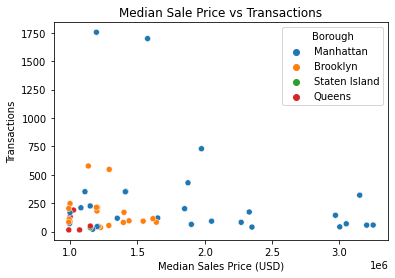

In [19]:
import seaborn as sns
# Plot transactions vs price - by borough
cluster_stats = sns.scatterplot(x=ny_merged['Median Sales Price (USD)'].astype(int), y=ny_merged['Transactions'], data=ny_merged, hue=ny_merged['Borough'])
cluster_stats.set_title("Median Sale Price vs Transactions")
cluster_stats

Now let's try and see which boroughs would provide the highest income compared to the total number of transactions

<AxesSubplot:title={'center':'Total Income vs Transactions'}, xlabel='Total Income', ylabel='Transactions'>

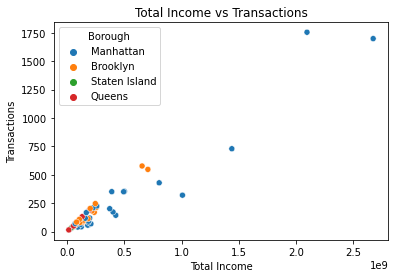

In [85]:
# Plot transactions vs total income - by borough
cluster_stats = sns.scatterplot(x=ny_merged['Total Income'], y=ny_merged['Transactions'], data=ny_merged, hue=ny_merged['Borough'])
cluster_stats.set_title("Total Income vs Transactions")
cluster_stats

### Let's dive a bit deeper into the venues

<AxesSubplot:title={'center':'Venue vs Median Sales Price (USD)'}, xlabel='Median Sales Price (USD)', ylabel='1st Most Common Venue'>

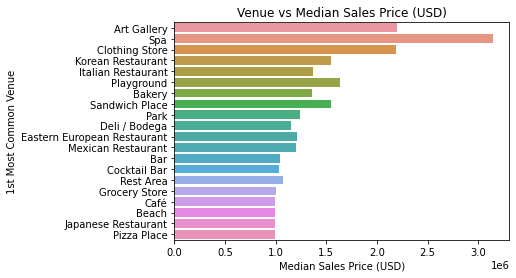

In [71]:
# Let's create a seaborn plot to see which venues yield higher prices
venue_price = sns.barplot(y=ny_merged['1st Most Common Venue'], x=ny_merged['Median Sales Price (USD)'], ci=None)
venue_price.set_title('Venue vs Median Sales Price (USD)')
venue_price

<AxesSubplot:title={'center':'Venue vs Transactions'}, xlabel='Transactions', ylabel='1st Most Common Venue'>

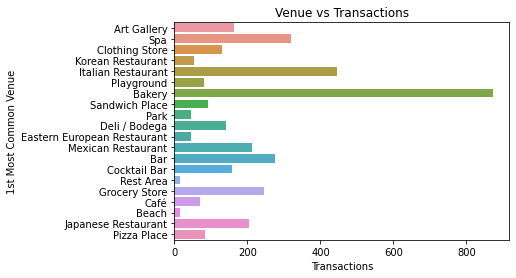

In [72]:
# Let's use seaborn to figure out which venues yield higher numbers of transactions
venue_sales = sns.barplot(y=ny_merged['1st Most Common Venue'], x=ny_merged['Transactions'], ci=None)
venue_sales.set_title('Venue vs Transactions')
venue_sales

<AxesSubplot:title={'center':'Venue vs Total Income'}, xlabel='Total Income', ylabel='1st Most Common Venue'>

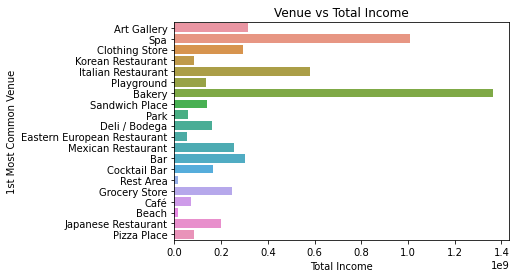

In [73]:
# Let's use seaborn to figure out which venues yield the highest return
venue_income = sns.barplot(y=ny_merged['1st Most Common Venue'], x=ny_merged['Total Income'], ci=None)
venue_income.set_title('Venue vs Total Income')
venue_income

Now let's dive deeper into the clusters

<AxesSubplot:title={'center':'Clusters vs Median Sales Price (USD)'}, xlabel='Cluster Labels', ylabel='Median Sales Price (USD)'>

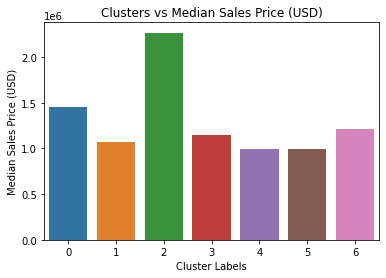

In [83]:
# Let's create a seaborn plot to see which clusters yield higher prices
cluster_price = sns.barplot(x=ny_merged['Cluster Labels'], y=ny_merged['Median Sales Price (USD)'], ci=None)
cluster_price.set_title('Clusters vs Median Sales Price (USD)')
cluster_price

<AxesSubplot:title={'center':'Clusters vs Transactions'}, xlabel='Cluster Labels', ylabel='Transactions'>

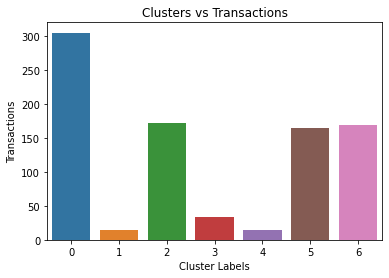

In [80]:
# Let's use seaborn to figure out which clusters yield higher numbers of transactions
cluster_sales = sns.barplot(x=ny_merged['Cluster Labels'], y=ny_merged['Transactions'], ci=None)
cluster_sales.set_title('Clusters vs Transactions')
cluster_sales

<AxesSubplot:title={'center':'Clusters vs Total Income'}, xlabel='Cluster Labels', ylabel='Total Income'>

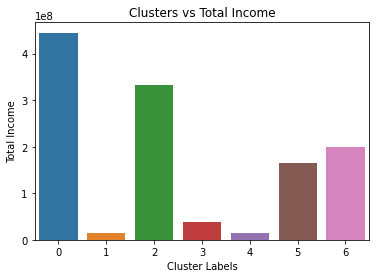

In [78]:
# Let's use seaborn to figure out which clusters yield the highest return
cluster_income = sns.barplot(x=ny_merged['Cluster Labels'], y=ny_merged['Total Income'], ci=None)
cluster_income.set_title('Clusters vs Total Income')
cluster_income

## Visualize clusters

In [22]:
# Map variables
address = 'New York, NY'

geolocator = Nominatim(user_agent="new_york_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Convert clusters to in
ny_clusters = ny_merged.fillna(0)
ny_clusters = ny_clusters['Cluster Labels'].astype(int)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ny_merged['Latitude'], ny_merged['Longitude'], ny_merged['Neighborhood'], ny_clusters):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


## Examine Clusters
### Cluster 1

In [23]:
ny_merged.loc[ny_merged['Cluster Labels'] == 0, ny_merged.columns[[0] + [3] + list(range(4, ny_merged.shape[1]))]]

,Neighborhood,Borough,Median Sales Price (USD),Transactions,Total Income,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Tribeca,Manhattan,3150000.0,320,1008000000,0,Spa,Coffee Shop,Café,Italian Restaurant,American Restaurant,Greek Restaurant,Gym / Fitness Center,Park,Cocktail Bar,Steakhouse
7,Soho,Manhattan,2330000.0,172,400760000,0,Clothing Store,Italian Restaurant,Dessert Shop,Women's Store,Boutique,Bakery,Shoe Store,Sushi Restaurant,Café,Mediterranean Restaurant
9,Hudson Square/West Soho,Manhattan,2050000.0,91,186550000,0,Clothing Store,Italian Restaurant,Dessert Shop,Women's Store,Boutique,Bakery,Shoe Store,Sushi Restaurant,Café,Mediterranean Restaurant
11,Nomad,Manhattan,1900000.0,63,119700000,0,Korean Restaurant,Hotel,Gym / Fitness Center,Italian Restaurant,Spa,American Restaurant,Pizza Place,New American Restaurant,Coffee Shop,Dessert Shop
12,Lenox Hill,Manhattan,1875000.0,429,804375000,0,Italian Restaurant,Sushi Restaurant,Coffee Shop,Pizza Place,Gym / Fitness Center,Greek Restaurant,Café,Sandwich Place,Mexican Restaurant,Bank
15,Cobble Hill,Brooklyn,1640000.0,82,134480000,0,Playground,Coffee Shop,Italian Restaurant,Bar,Cocktail Bar,Bakery,Dive Bar,Pizza Place,Japanese Restaurant,Dog Run
17,Upper West Side,Manhattan,1575000.0,1699,2675925000,0,Bakery,Italian Restaurant,American Restaurant,Seafood Restaurant,Ice Cream Shop,Cosmetics Shop,Bar,Coffee Shop,Café,Yoga Studio
19,Fort Greene,Brooklyn,1437500.0,94,135125000,0,Italian Restaurant,Coffee Shop,Lounge,Opera House,Cosmetics Shop,Ice Cream Shop,Theater,Performing Arts Venue,Grocery Store,Caribbean Restaurant
21,West Village,Manhattan,1410000.0,350,493500000,0,Italian Restaurant,American Restaurant,Cocktail Bar,Coffee Shop,Park,New American Restaurant,Bakery,Jazz Club,Indian Restaurant,Café
23,Dumbo,Brooklyn,1395000.0,80,111600000,0,Park,American Restaurant,Boat or Ferry,Scenic Lookout,Yoga Studio,Boxing Gym,Bookstore,Roof Deck,Bakery,Gym


### Cluster 2

In [24]:
ny_merged.loc[ny_merged['Cluster Labels'] == 1, ny_merged.columns[[0] + [3] + list(range(4, ny_merged.shape[1]))]]

,Neighborhood,Borough,Median Sales Price (USD),Transactions,Total Income,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
41,Malba,Queens,1070000.0,14,14980000,1,Rest Area,Tennis Court,Bus Line,Peruvian Restaurant,Persian Restaurant,Perfume Shop,Performing Arts Venue,Pedestrian Plaza,Park,Paper / Office Supplies Store


### Cluster 3

In [25]:
ny_merged.loc[ny_merged['Cluster Labels'] == 2, ny_merged.columns[[0] + [3] + list(range(4, ny_merged.shape[1]))]]

,Neighborhood,Borough,Median Sales Price (USD),Transactions,Total Income,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Noho,Manhattan,3250000.0,57,185250000,2,Art Gallery,Gym / Fitness Center,Coffee Shop,Bar,Park,Cocktail Bar,Pier,Pedestrian Plaza,Clothing Store,Indie Theater
1,Hudson Yards,Manhattan,3201875.0,56,179305000,2,Art Gallery,Gym / Fitness Center,Coffee Shop,Bar,Park,Cocktail Bar,Pier,Pedestrian Plaza,Clothing Store,Indie Theater
3,Central Park South,Manhattan,3050218.5,68,207414824,2,Art Gallery,Gym / Fitness Center,Coffee Shop,Bar,Park,Cocktail Bar,Pier,Pedestrian Plaza,Clothing Store,Indie Theater
4,Nolita,Manhattan,3002146.0,41,123087986,2,Art Gallery,Gym / Fitness Center,Coffee Shop,Bar,Park,Cocktail Bar,Pier,Pedestrian Plaza,Clothing Store,Indie Theater
5,Theatre District,Manhattan,2970000.0,143,424710000,2,Art Gallery,Gym / Fitness Center,Coffee Shop,Bar,Park,Cocktail Bar,Pier,Pedestrian Plaza,Clothing Store,Indie Theater
6,Bowery,Manhattan,2350000.0,39,91650000,2,Art Gallery,Gym / Fitness Center,Coffee Shop,Bar,Park,Cocktail Bar,Pier,Pedestrian Plaza,Clothing Store,Indie Theater
8,Civic Center,Manhattan,2270000.0,81,183870000,2,Art Gallery,Gym / Fitness Center,Coffee Shop,Bar,Park,Cocktail Bar,Pier,Pedestrian Plaza,Clothing Store,Indie Theater
10,Lincoln Square,Manhattan,1975000.0,729,1439775000,2,Art Gallery,Gym / Fitness Center,Coffee Shop,Bar,Park,Cocktail Bar,Pier,Pedestrian Plaza,Clothing Store,Indie Theater
13,Carnegie Hill,Manhattan,1850000.0,201,371850000,2,Art Gallery,Gym / Fitness Center,Coffee Shop,Bar,Park,Cocktail Bar,Pier,Pedestrian Plaza,Clothing Store,Indie Theater
14,Flatiron,Manhattan,1650000.0,119,196350000,2,Art Gallery,Gym / Fitness Center,Coffee Shop,Bar,Park,Cocktail Bar,Pier,Pedestrian Plaza,Clothing Store,Indie Theater


### Cluster 4

In [26]:
ny_merged.loc[ny_merged['Cluster Labels'] == 3, ny_merged.columns[[0] + [3] + list(range(4, ny_merged.shape[1]))]]

,Neighborhood,Borough,Median Sales Price (USD),Transactions,Total Income,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
35,Todt Hill,Staten Island,1150000.0,33,37950000,3,Park,Mountain,Donut Shop,Accessories Store,Pet Café,Peruvian Restaurant,Persian Restaurant,Perfume Shop,Performing Arts Venue,Pedestrian Plaza


### Cluster 5

In [27]:
ny_merged.loc[ny_merged['Cluster Labels'] == 4, ny_merged.columns[[0] + [3] + list(range(4, ny_merged.shape[1]))]]

,Neighborhood,Borough,Median Sales Price (USD),Transactions,Total Income,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
49,Neponsit,Queens,990000.0,14,13860000,4,Beach,Park,Pizza Place,Bus Stop,Accessories Store,Peruvian Restaurant,Persian Restaurant,Perfume Shop,Performing Arts Venue,Pedestrian Plaza


In [28]:
ny_merged.loc[ny_merged['Cluster Labels'] == 5, ny_merged.columns[[0] + [3] + list(range(4, ny_merged.shape[1]))]]

,Neighborhood,Borough,Median Sales Price (USD),Transactions,Total Income,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
46,Borough Park,Brooklyn,999000.0,246,245754000,5,Grocery Store,Bakery,Pizza Place,Metro Station,Bus Stop,Fast Food Restaurant,Candy Store,Accessories Store,Pet Café,Peruvian Restaurant
51,Mapleton,Brooklyn,990000.0,83,82170000,5,Pizza Place,Lounge,Grocery Store,Pharmacy,Bakery,Bagel Shop,Italian Restaurant,Fried Chicken Joint,Accessories Store,Peruvian Restaurant


In [29]:
ny_merged.loc[ny_merged['Cluster Labels'] == 6, ny_merged.columns[[0] + [3] + list(range(4, ny_merged.shape[1]))]]

,Neighborhood,Borough,Median Sales Price (USD),Transactions,Total Income,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,Carroll Gardens,Brooklyn,1615000.0,113,182495000,6,Italian Restaurant,Coffee Shop,Bakery,Bar,Wine Shop,Spa,Pizza Place,Yoga Studio,Seafood Restaurant,Brewery
18,Boerum Hill,Brooklyn,1542260.0,91,140345660,6,Sandwich Place,Bar,Furniture / Home Store,Gym,Japanese Restaurant,Indian Restaurant,Climbing Gym,Italian Restaurant,Board Shop,Deli / Bodega
22,South Slope,Brooklyn,1400000.0,169,236600000,6,Italian Restaurant,Bar,Coffee Shop,American Restaurant,Wine Shop,Gym,Grocery Store,Wine Bar,Café,Jewelry Store
27,Columbia Waterfront District,Brooklyn,1225000.0,35,42875000,6,Deli / Bodega,Italian Restaurant,Coffee Shop,Motorcycle Shop,Thai Restaurant,Playground,Bar,Harbor / Marina,Museum,Bookstore
29,Prospect Heights,Brooklyn,1204000.0,212,255248000,6,Mexican Restaurant,Bar,Coffee Shop,Cocktail Bar,Ice Cream Shop,Plaza,Pizza Place,Thai Restaurant,Bakery,Southern / Soul Food Restaurant
38,Williamsburg,Brooklyn,1135000.0,577,654895000,6,Bar,Bakery,Pizza Place,Chinese Restaurant,Coffee Shop,Deli / Bodega,Mexican Restaurant,Latin American Restaurant,Sushi Restaurant,Burger Joint
43,Ridgewood,Queens,999999.0,131,130999869,6,Deli / Bodega,Pizza Place,Supermarket,Ice Cream Shop,Bar,Bank,Bakery,Gift Shop,Grocery Store,Donut Shop
44,East Williamsburg,Brooklyn,999500.0,86,85957000,6,Bar,Deli / Bodega,Coffee Shop,Brewery,Mexican Restaurant,Gymnastics Gym,Cocktail Bar,Park,Smoke Shop,Pizza Place
45,East Village,Manhattan,999000.0,167,166833000,6,Bar,Cocktail Bar,Korean Restaurant,Vietnamese Restaurant,Wine Bar,Garden,Vegetarian / Vegan Restaurant,Pizza Place,Coffee Shop,Park
48,Gowanus,Brooklyn,992793.0,107,106228851,6,Cocktail Bar,Park,Bagel Shop,Pie Shop,Spa,Colombian Restaurant,Comic Shop,Pet Store,Seafood Restaurant,Furniture / Home Store
